# <center> Project-3. EDA+Feature Engineering
---
## <center> Вводные данные и подготовка к работе
---

Первоначальная версия датасета содержит 17 полей со следующей информацией:

- hotel_address — адрес отеля;

- review_date — дата, когда рецензент разместил соответствующий отзыв;

- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

- hotel_name — название отеля;

- reviewer_nationality — страна рецензента;

- negative_review — отрицательный отзыв, который рецензент дал отелю;

- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

- positive_review — положительный отзыв, который рецензент дал отелю;

- review_total_positive_word_counts — общее количество слов в положительном отзыве.

- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

- total_number_of_reviews — общее количество действительных отзывов об отеле;

- tags — теги, которые рецензент дал отелю;

- days_since_review — количество дней между датой проверки и датой очистки;

- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

- lat — географическая широта отеля;

- lng — географическая долгота отеля.

In [322]:
# Импорты
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import category_encoders as ce
import plotly.express as px
import numpy as np
import nltk

from sklearn import preprocessing
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from nltk.sentiment import SentimentIntensityAnalyzer

In [323]:
hotels = pd.read_csv('data/hotels.csv')
display(hotels.head())
display(hotels.info())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

---
## <center> Очистка данных
---

Для начала удалим дубликаты, если они есть.

In [324]:
mask_dupl = hotels.duplicated(subset=list(hotels.columns))
hotels_duplicates = hotels[mask_dupl]
print(f'Найдено дубликатов: {hotels_duplicates.shape[0]}')

hotels = hotels.drop_duplicates(subset=list(hotels.columns))
print(f'Результирующее число записей: {hotels.shape[0]}')

Найдено дубликатов: 307
Результирующее число записей: 386496


Оценим корреляцию изначальных числовых признаков.

In [325]:
hotels.isna().value_counts()

hotel_address  additional_number_of_scoring  review_date  average_score  hotel_name  reviewer_nationality  negative_review  review_total_negative_word_counts  total_number_of_reviews  positive_review  review_total_positive_word_counts  total_number_of_reviews_reviewer_has_given  reviewer_score  tags   days_since_review  lat    lng  
False          False                         False        False          False       False                 False            False                              False                    False            False                              False                                       False           False  False              False  False    384048
                                                                                                                                                                                                                                                                                                                                

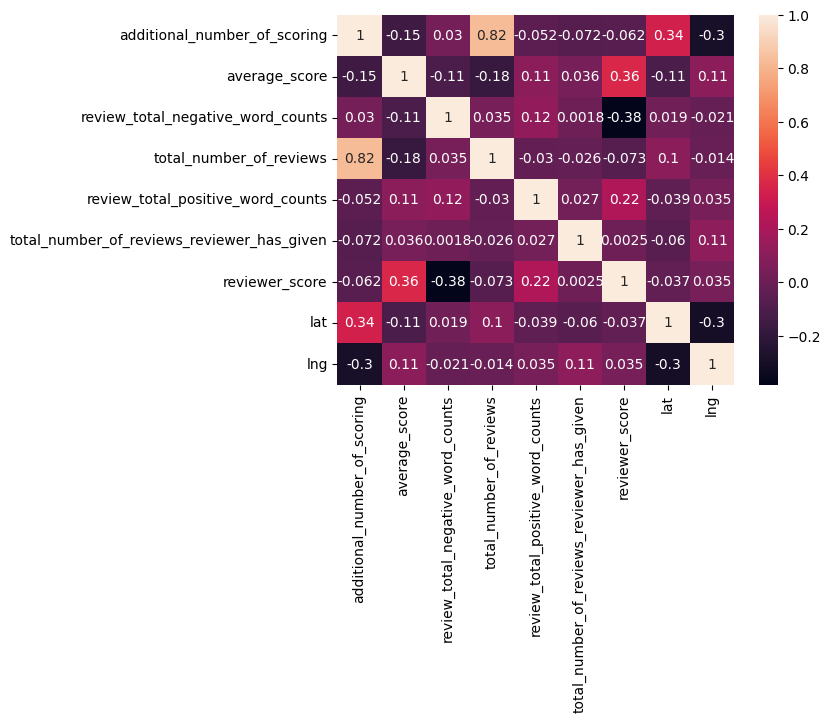

In [326]:
sns.heatmap(hotels.corr(numeric_only=True), annot=True);

Видим высокие значения корреляции у признаков total_number_of_reviews и addditional_number_of_scoring. Пока с ними ничего не делаем, просто имеем это в виду. Вернёмся к ним после отбора признаков.

In [327]:
#Задание 4.2 - количество наименований отелей
hotels['hotel_name'].value_counts()

hotel_name
Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
                                                     ... 
Ibis Styles Milano Palmanova                            7
Renaissance Paris Republique Hotel Spa                  7
Hotel Wagner                                            6
Hotel Gallitzinberg                                     6
Mercure Paris Porte d Orleans                           5
Name: count, Length: 1492, dtype: int64

In [328]:
#Приведём даты к формату datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'], dayfirst=True)

#Задание 4.3
print('Дата самого первого отзыва:\n',
      hotels['review_date'].sort_values().head(1))
print('Дата самого свежего отзыва:\n',
      hotels['review_date'].sort_values(ascending=False).head(1))

Дата самого первого отзыва:
 318705   2015-08-04
Name: review_date, dtype: datetime64[ns]
Дата самого свежего отзыва:
 318267   2017-08-03
Name: review_date, dtype: datetime64[ns]


C:\Users\telis\AppData\Local\Temp\ipykernel_87744\3725267793.py:2: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  hotels['review_date'] = pd.to_datetime(hotels['review_date'], dayfirst=True)


In [329]:
#Приведём столбец days_since_review к удобоваримому 
#для модели виду, убрав 'day' в конце

def day_transf(table_string):
    
    """ Функция-преобразователь для преобразования
    столбца 'days_since_review'.

    Args:
        table_string (_string_): принимает на вход 
        строку из столбца

    Returns:
        _string_: возвращает преобразованную строку
    """    
    
    word_list = table_string.split(' ')
    
    return int(word_list[0])

hotels['days_since_review'] = hotels['days_since_review'].apply(day_transf)

#Проверим результат
hotels['days_since_review'].head(3)

0    531
1    203
2    289
Name: days_since_review, dtype: int64

In [330]:
def cities_convert(string):
    
    """Функция для конвертации страны из адреса.
    
    Есть 2 способа работы функции:
    1) Поиск в адресе столицы и конвертации её
    в страну.
    2) Если страна находится в конце адреса,
    можно взять последнее слово.
    
    В данном датасете быстрее работает второй способ.

    Args:
        string (_str_): строчка датасета 

    Returns:
        _str_: строчка со страной
    """    
    #Столицы Европейских городов
    europe_capital_cities = ['Amsterdam', 'Andora La Vella', 'Athens', 'Belgrade', 'Berlin', 'Bern', 'Bratislava', 'Brussels', 'Bucharest', 'Budapest', 'Chisinau', 'Dublin', 'Helsinki', 'Kiev', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Madrid', 'Minsk', 'Monako', 'Moskow', 'Nicosia', 'Copenhagen', 'Nuuk', 'Oslo', 'Paris', 'Podgorica', 'Prague', 'Reykjavik', 'Riga', 'Rome', 'San Marino', 'Sarajevo', 'Skopje', 'Sofia', 'Stockholm', 'Tallinn', 'Tirana', 'Vaduz', 'Valletta', 'Vatican City', 'Vienna', 'Vilnius', 'Warsaw', 'Zagreb']
    #Словарь столица-страна
    europe_cities_to_countries_dict = {'Amsterdam':'Netherlands', 'Andora La Vella':'Andorra', 'Athens':'Greece', 'Belgrade':'Serbia', 'Berlin':'Germany', 'Bern':'Switzerland', 'Bratislava':'Slovakia', 'Brussels':'Belgium', 'Bucharest':'Romania', 'Budapest':'Hungary', 'Chisinau':'Moldova', 'Copenhagen':'Denmark', 'Dublin':'Ireland', 'Helsinki':'Finland', 'Kiev':'Ukraine', 'Lisbon':'Portugal', 'Ljubljana':'Slovenia', 'London':'United Kingdom', 'Luxembourg':'Luxembourg', 'Madrid':'Spain', 'Minsk':'Belarus', 'Monako':'Monaco', 'Moskow':'Russia', 'Nicosia':'Cyprus', 'Nuuk':'Greenland', 'Oslo':'Norway', 'Paris':'France', 'Podgorica':'Montenegro', 'Prague':'Czech Republic', 'Reykjavik':'Iceland', 'Riga':'Latvia', 'Rome':'Italy', 'San Marino':'San Marino', 'Sarajevo':'Bosnia & Herzegovina', 'Skopje':'North Macedonia', 'Sofia':'Bulgaria', 'Stockholm':'Sweden', 'Tallinn':'Estonia', 'Tirana':'Albania', 'Vaduz':'Liechtenstein', 'Valletta':'Malta', 'Vatican City':'Holy See', 'Vienna':'Austria', 'Vilnius':'Lithuania', 'Warsaw':'Poland', 'Zagreb':'Croatia'}
    europe_capitals_list = europe_cities_to_countries_dict.values()
    
    word_list = string.split(' ')
    capital = word_list[-1]
    if capital == 'Kingdom':
        return word_list[-2] + ' ' + word_list[-1]
    else:
        return capital
    # for word in word_list:
    #     if word in europe_capital_cities:
    #         return europe_cities_to_countries_dict[word]
    #     elif word == 'Vatican':
    #         return 'Holy Sea'
    #     elif word == 'Andora':
    #         return 'Andorra'
    #     elif word == 'San Marino':
    #         return word
    #     else:
    #         return 'other'
        

hotels['hotel_country'] = hotels['hotel_address'].apply(cities_convert)
hotels.drop(['hotel_address'], axis=1, inplace=True)

Город вычленять отдельно не стал, смысла нет, если вычленилась страна.

In [331]:
hotels['review_day'] = hotels['review_date'].dt.day_of_week

In [332]:
def season_convert(date):
    
    if date.month in [3,4,5]:
        return 2
    elif date.month in [6,7,8]:
        return 3
    elif date.month in [9,10,11]:
        return 4
    elif date.month in [12,1,2]:
        return 1
    
hotels['season'] = hotels['review_date'].apply(season_convert)

In [333]:
#Вытянем уникальные теги из соответствующего столбца
tags_list = []

tags_dataset = hotels.copy()

def sep_tags_func(tags_string):
    #Мини-функция для удаления пробелов
    tags = tags_string[2:-2]
    tags_splitted = tags.strip().split(' \', \' ')
    return tags_splitted

tags_dataset['tags'] = tags_dataset['tags'].apply(sep_tags_func)
tags_dataset = tags_dataset.explode('tags')


In [334]:
#Задание 4.4
print('Количество уникальных тегов:',
      len(tags_dataset['tags'].unique()))  #2368
print('-'*100)
#Задание 4.5
print('Самый частый тег:',
      tags_dataset['tags'].value_counts().head(1))  #Leisure trip
#Задание 4.6
tags_dataset['tags'].value_counts()  #1

Количество уникальных тегов: 2368
----------------------------------------------------------------------------------------------------
Самый частый тег: tags
Leisure trip    313353
Name: count, dtype: int64


tags
Leisure trip                         313353
Submitted from a mobile device       230608
Couple                               189046
Stayed 1 night                       145296
Stayed 2 nights                      100176
                                      ...  
Studio with Spa Access                    1
Comfort Family Room                       1
Junior Suite Free Wifi                    1
Design Suite                              1
Executive Double Room Non Smoking         1
Name: count, Length: 2368, dtype: int64

In [335]:
#Посчитаем кол-во тегов на каждом отзыве

hotels['tags_count'] = hotels['tags'].apply(lambda x: len(sep_tags_func(x)))

In [336]:
#Делаем из посчитанных данных обычный список из тегов
tags = tags_dataset['tags'].value_counts().reset_index()
tags.columns = ['Tag', 'Counter']
tags_list = tags['Tag'].to_list()
display(tags_list)

#Делаем список тегов времени проживания в отеле
stay_list = []
for item in tags_list:
    if 'Stayed' in item.split():
        if item not in stay_list:
            stay_list.append(item)
        else:
            continue
        
        
def tags_convert_func(string):
    global stay_list
    sep_string = string[2:-2]
    sep_string = sep_string.strip().split(' \', \' ')
    for tag in sep_string:
        if tag in stay_list:
            if tag.split(' ')[1] != np.NaN:
                return int(tag.split(' ')[1])
            else:
                return 0

hotels['stay_status'] = hotels['tags'].apply(tags_convert_func)

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room',
 'Superior Double or Twin Room',
 '2 rooms',
 'Stayed 6 nights',
 'Standard Twin Room',
 'Single Room',
 'Twin Room',
 'Stayed 7 nights',
 'Executive Double Room',
 'Classic Double or Twin Room',
 'Superior Twin Room',
 'Club Double Room',
 'Deluxe Double or Twin Room',
 'Queen Room',
 'Deluxe King Room',
 'Superior Queen Room',
 'Standard Single Room',
 'Junior Suite',
 'Triple Room',
 'Classic Room',
 'Superior Room',
 'Superior King Room',
 'Standard Room',
 'Deluxe Room',
 'Double Guest Room',
 'Standard Queen Room',
 'Deluxe Single Room',
 'Small Do

In [337]:
#Создаём временные признаки настроения из имеющихся отзывов
nltk.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

hotels['negative'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
hotels['positive'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\telis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [338]:
#Проверяем результат и выводим значения для дальнейшего преобразования
hotels[['negative', 'positive']]

,negative,positive
0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp..."
1,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp..."
3,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.279, 'pos': 0.721, 'comp..."
4,"{'neg': 0.667, 'neu': 0.333, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'comp..."
...,...,...
386798,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
386799,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.045, 'neu': 0.857, 'pos': 0.098, 'co..."
386800,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'comp..."
386801,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [339]:
hotels['neg_to_neg'] = hotels['negative'].apply(lambda x: x['neg'])
hotels['neg_to_pos'] = hotels['negative'].apply(lambda x: x['pos'])
hotels['neg_to_neu'] = hotels['negative'].apply(lambda x: x['neu'])
hotels['neg_to_compound'] = hotels['negative'].apply(lambda x: x['compound'])

hotels['pos_to_neg'] = hotels['positive'].apply(lambda x: x['neg'])
hotels['pos_to_pos'] = hotels['positive'].apply(lambda x: x['pos'])
hotels['pos_to_neu'] = hotels['positive'].apply(lambda x: x['neu'])
hotels['pos_to_compound'] = hotels['positive'].apply(lambda x: x['compound'])

In [340]:
#Делаем признаки-мигалки из некоторых тегов
hotels['Leisure_trip'] = hotels['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
hotels['Business_trip'] = hotels['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)
hotels['Submitted_from_mobile'] = hotels['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)
hotels['Solo_traveler'] = hotels['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)
hotels['Couple'] = hotels['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
hotels['Family_with_young_children'] = hotels['tags'].apply(lambda x: 1 if 'Family with young children' in x else 0)
hotels['Family_with_older_children'] = hotels['tags'].apply(lambda x: 1 if 'Family with older children' in x else 0)
hotels['Group'] = hotels['tags'].apply(lambda x: 1 if 'Group' in x else 0)

In [341]:
#Закодируем признаки однократным кодированием,
#удалим закодированные столбцы

#страна дислокации отеля
oneHotEncoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True)
type_bin = oneHotEncoder.fit_transform(hotels[['hotel_country']])
hotels = pd.concat([hotels, type_bin], axis=1)

hotels.drop(['hotel_country'], axis=1, inplace=True)

In [342]:
#Закодируем бинарным кодированием, удалим 
#закодированные столбцы

#Гражданство страны
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

#Имена отелей
bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(hotels['hotel_name'])
hotels = pd.concat([hotels, type_bin], axis=1)

# #Количество ночей
# bin_encoder = ce.BinaryEncoder(cols=['stay_status'])
# type_bin = bin_encoder.fit_transform(hotels['stay_status'])
# hotels = pd.concat([hotels, type_bin], axis=1)

hotels.drop(['reviewer_nationality', 'hotel_name'], axis=1, inplace=True)

In [343]:
hotels

,additional_number_of_scoring,review_date,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,review_day,tags_count,stay_status,negative,positive,neg_to_neg,neg_to_pos,neg_to_neu,neg_to_compound,pos_to_neg,pos_to_pos,pos_to_neu,pos_to_compound,Leisure_trip,Business_trip,Submitted_from_mobile,Solo_traveler,Couple,Family_with_young_children,Family_with_older_children,Group,hotel_country_United Kingdom,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,hotel_country_Spain,season_Winter,season_Autumn,season_Spring,season_Summer,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
0,581,2016-02-19,8.4,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531,51.507894,-0.143671,4,5,2.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp...",0.000,0.0,1.000,0.0000,0.000,0.655,0.345,0.5859,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,299,2017-01-12,8.3,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203,51.521009,-0.123097,3,4,1.0,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.756,0.0,0.244,-0.4767,0.000,0.000,1.000,0.0000,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,32,2016-10-18,8.9,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289,48.845377,2.325643,1,5,3.0,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",0.423,0.0,0.577,-0.2960,0.379,0.621,0.000,0.3400,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
3,34,2015-09-22,7.5,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681,48.888697,2.394540,1,4,1.0,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.279, 'pos': 0.721, 'comp...",1.000,0.0,0.000,-0.7096,0.000,0.721,0.279,0.9169,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,914,2016-03-05,8.5,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516,52.385601,4.847060,5,4,6.0,"{'neg': 0.667, 'neu': 0.333, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'comp...",0.667,0.0,0.333,-0.2500,0.000,0.382,0.618,0.8503,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,107,2017-04-19,9.0,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.8,"[' Leisure trip ', ' Group ', ' Club Double or...",106,51.494028,-0.191050,2,5,2.0,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1.000,0.0,0.000,-0.7096,0.000,0.000,1.000,0.0000,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,1,1
386799,272,2017-02-13,8.4,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.2,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171,48.192379,16.399451,0,5,4.0,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.045, 'neu': 0.857, 'pos': 0.098, 'co...",1.000,0.0,0.000,-0.7096,0.045,0.098,0.857,

In [344]:
hotels.columns

Index(['additional_number_of_scoring', 'review_date', 'average_score',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'review_day', 'tags_count',
       'stay_status', 'negative', 'positive', 'neg_to_neg', 'neg_to_pos',
       'neg_to_neu', 'neg_to_compound', 'pos_to_neg', 'pos_to_pos',
       'pos_to_neu', 'pos_to_compound', 'Leisure_trip', 'Business_trip',
       'Submitted_from_mobile', 'Solo_traveler', 'Couple',
       'Family_with_young_children', 'Family_with_older_children', 'Group',
       'hotel_country_United Kingdom', 'hotel_country_France',
       'hotel_country_Netherlands', 'hotel_country_Italy',
       'hotel_country_Austria', 'hotel_country_Spain', 'season_Winter',
       'season_Autumn', 'season_Spring', 'season_Summer',
       'reviewer_n

In [345]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 
            'review_total_negative_word_counts', 
            'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given', 
            'days_since_review',
            'tags_count'
]

# категориальные признаки
cat_cols = [
    'average_score', 
    'hotel_country_United Kingdom', 
    'hotel_country_France', 
    'hotel_country_Netherlands', 
    'hotel_country_Italy', 
    'hotel_country_Austria', 
    'hotel_country_Spain', 
    'stay_status',
    # 'stay_status_0', 
    # 'stay_status_1', 
    # 'stay_status_2', 
    # 'stay_status_3', 
    # 'stay_status_4',
    'Leisure_trip',
    'Business_trip',
    'Submitted_from_mobile',
    'Solo_traveler', 
    'Couple', 
    'Family_with_young_children', 
    'Family_with_older_children', 
    'Group',
    'hotel_name_0', 
    'hotel_name_1', 
    'hotel_name_2', 
    'hotel_name_3', 
    'hotel_name_4', 
    'hotel_name_5', 
    'hotel_name_6', 
    'hotel_name_7', 
    'hotel_name_8', 
    'hotel_name_9', 
    'hotel_name_10', 
    'season',
    'reviewer_nationality_0', 
    'reviewer_nationality_1', 
    'reviewer_nationality_2', 
    'reviewer_nationality_3', 
    'reviewer_nationality_4', 
    'reviewer_nationality_5', 
    'reviewer_nationality_6', 
    'reviewer_nationality_7', 
    'review_day'
]

In [346]:
# # # !!! Столбцы для первоначального получения MAPE. 
# # # Здесь необходимый минимум приготовлений для 
# # # получения модели !!!

#P.S. Оставлю эту часть здесь, на всякий 
#случай, она экономит время на дроп оставшихся
#строковых значений

object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)
hotels = hotels.fillna(0)

#местонахождение отеля нам не так важно, 
#раз мы знаем, в какой стране он находится,
#а дату мы уже использовали 
hotels.drop(['lat', 'lng', 'review_date', 'additional_number_of_scoring'], axis=1, inplace=True)

In [347]:
def show_corr_heatmap(columns_list, title, method):
    fig_, ax_ = plt.subplots(figsize=(15, 15))
    corr = hotels[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr,
                annot=True,
                linewidths=0.1,
                ax=ax_,
                mask=mask,
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

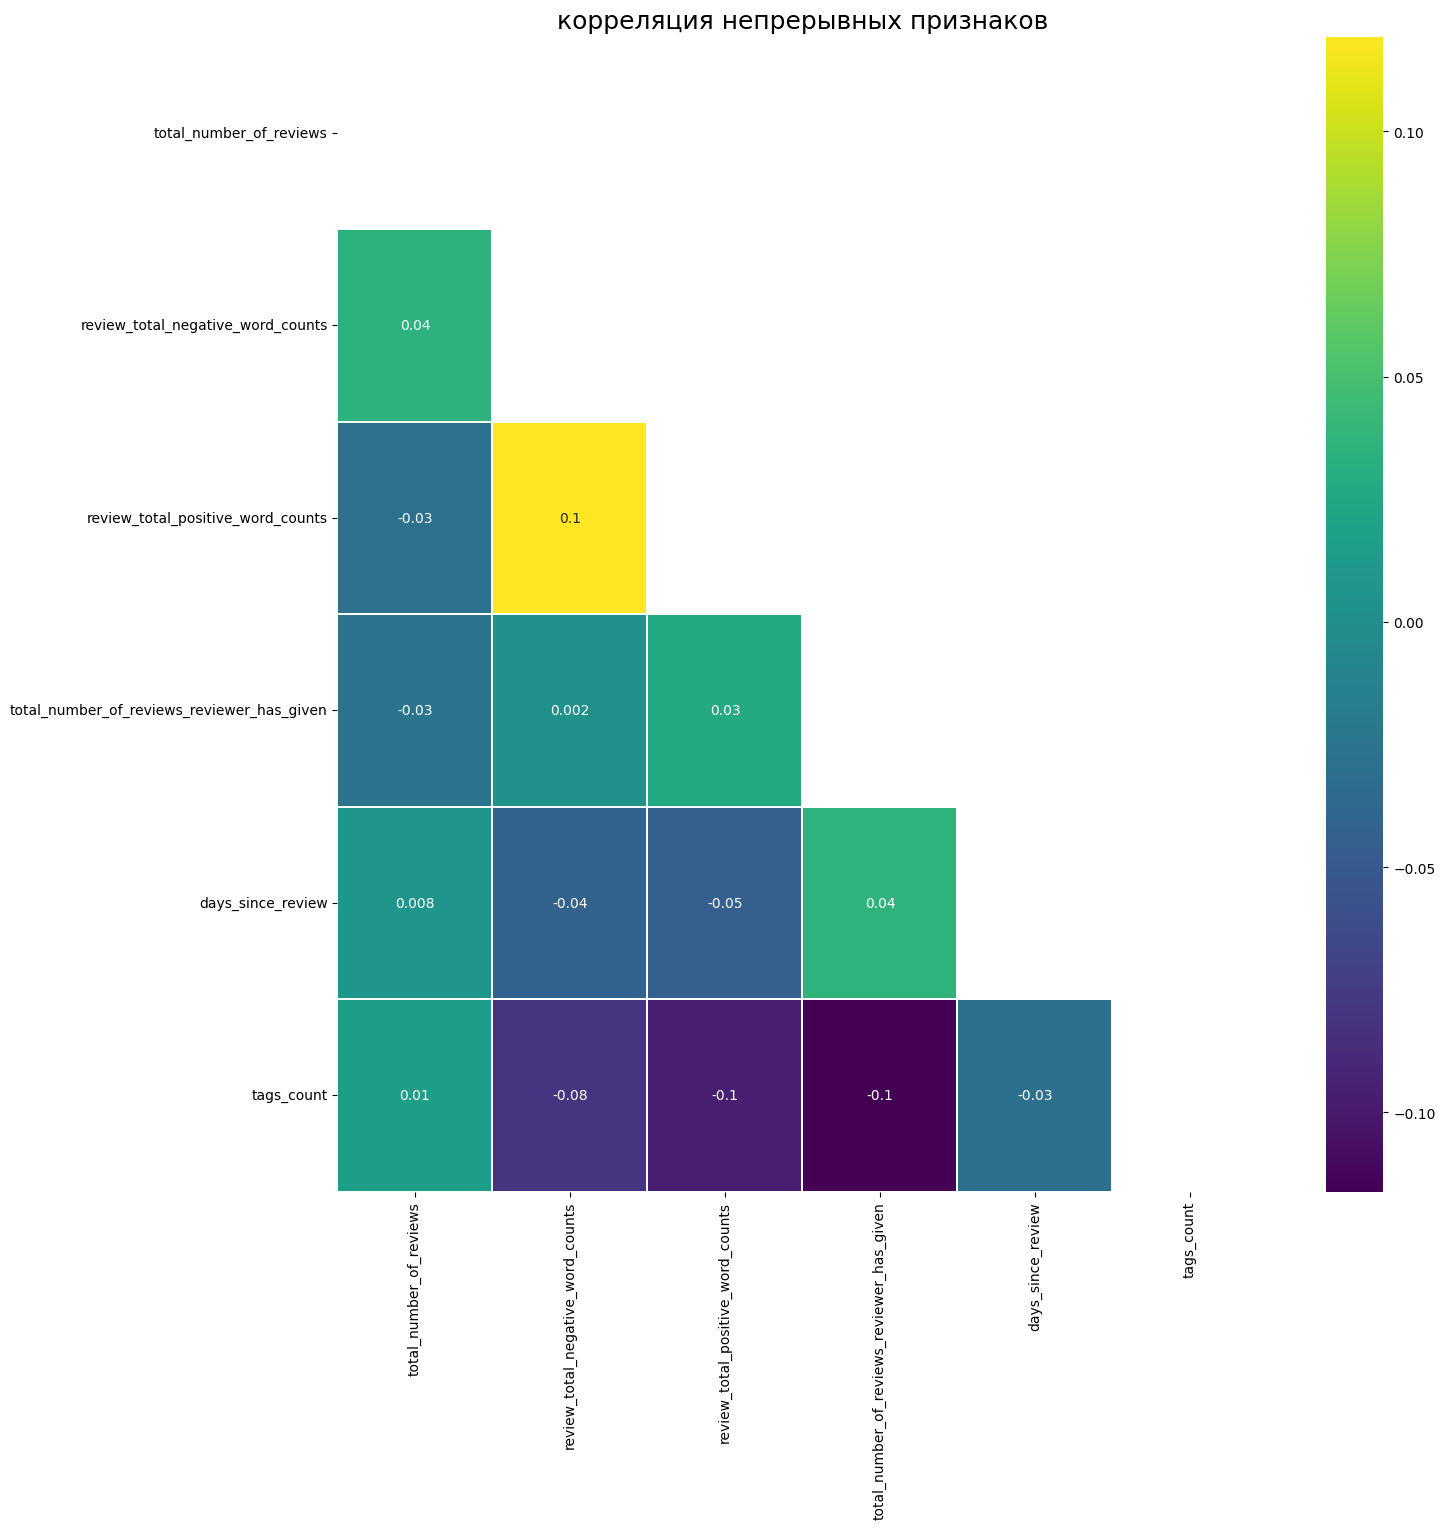

In [348]:
show_corr_heatmap(num_cols, 'корреляция непрерывных признаков', method='pearson')

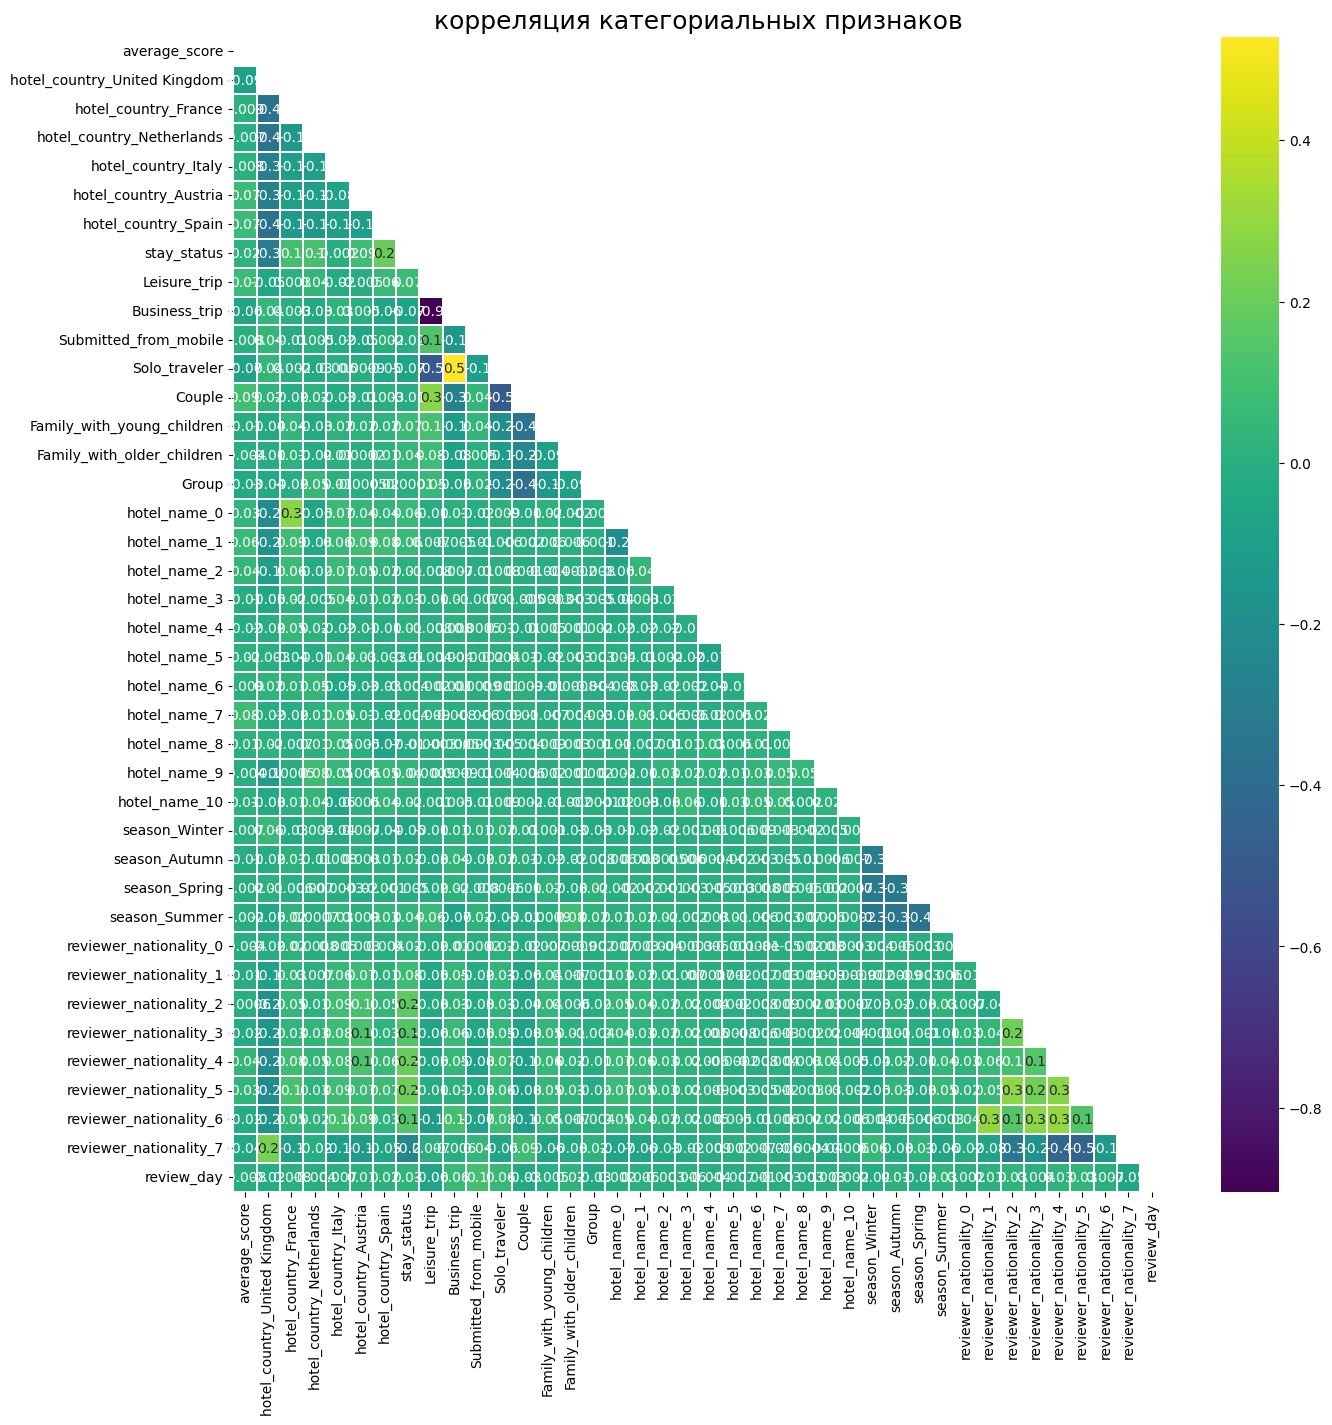

In [349]:
show_corr_heatmap(cat_cols, 'корреляция категориальных признаков', method='spearman')

In [350]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']

In [351]:
# y=y.astype('int')

# imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
# imp_cat.sort_values(inplace = True)
# imp_cat.plot(kind = 'barh', figsize=(10,10))

In [352]:
# imp_cat

Ничего необычного. Признаки-мигалки и закодированные не имеют особого влияния по одиночке, но без них эффективность предсказания падает. Выносить признаки из тегов не стал.

<Axes: >

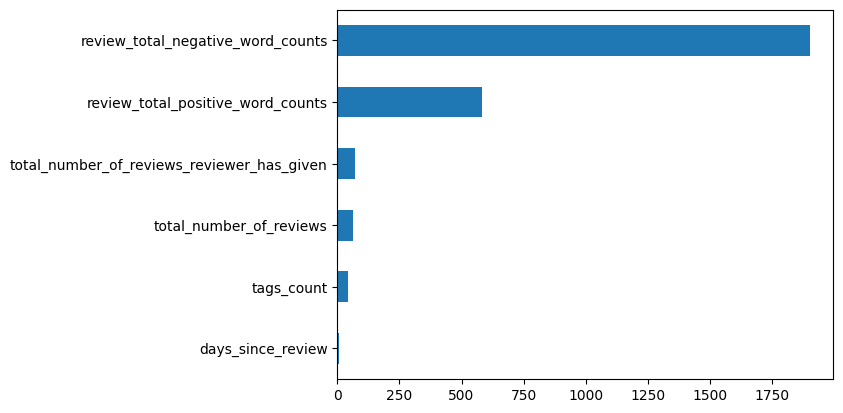

In [353]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [354]:
imp_num

days_since_review                                7.372380
tags_count                                      43.289727
total_number_of_reviews                         63.454704
total_number_of_reviews_reviewer_has_given      71.470907
review_total_positive_word_counts              581.651117
review_total_negative_word_counts             1904.244965
dtype: float64

days_since_review - незначимый. Лучше удалить его.

In [355]:
hotels.drop(['days_since_review'], axis=1, inplace=True)
# hotels.drop(['Leisure_trip'], axis=1, inplace=True)


А вот тут можно попробовать удалить четыре нижних признака. Или нормализовать их. 

Также вспоминаем, что два из этих четырёх признаков имели высокие показатели коллинеарности между друг другом.

До удаления: MAPE: 13,56%

После удаления: MAPE: 13,64%

Легко заметить, что графики подставлены вручную. Это сделано из-за того, что строчка y=y.astype('int') сильно ухудшает показания. А без неё не работает код для оценки значимости категориальных признаков. Потому я её просто закомментил, а сюда вставил получающиеся графики. Можно раскомментировать, но на ваш страх и риск (и ухудшение предсказания)!

In [356]:
# col_names = list(hotels.columns)

# mm_scaler = preprocessing.RobustScaler()
# hotels_mm = mm_scaler.fit_transform(hotels)
# hotels_mm = pd.DataFrame(hotels_mm, columns=col_names)

# #Поменяем обратно нормализованный целевой признак 
# # для правильности результатов
# hotels_mm.drop(['reviewer_score'], axis = 1, inplace=True)
# hotels_mm['reviewer_score'] = hotels['reviewer_score']

In [357]:
# # Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# # Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
# X = hotels_mm.drop(['reviewer_score'], axis = 1)  
# y = hotels_mm['reviewer_score']

---
## <center> Обучение модели
---

In [358]:
hotels.isna().value_counts()

average_score  review_total_negative_word_counts  total_number_of_reviews  review_total_positive_word_counts  total_number_of_reviews_reviewer_has_given  reviewer_score  review_day  tags_count  stay_status  neg_to_neg  neg_to_pos  neg_to_neu  neg_to_compound  pos_to_neg  pos_to_pos  pos_to_neu  pos_to_compound  Leisure_trip  Business_trip  Submitted_from_mobile  Solo_traveler  Couple  Family_with_young_children  Family_with_older_children  Group  hotel_country_United Kingdom  hotel_country_France  hotel_country_Netherlands  hotel_country_Italy  hotel_country_Austria  hotel_country_Spain  season_Winter  season_Autumn  season_Spring  season_Summer  reviewer_nationality_0  reviewer_nationality_1  reviewer_nationality_2  reviewer_nationality_3  reviewer_nationality_4  reviewer_nationality_5  reviewer_nationality_6  reviewer_nationality_7  hotel_name_0  hotel_name_1  hotel_name_2  hotel_name_3  hotel_name_4  hotel_name_5  hotel_name_6  hotel_name_7  hotel_name_8  hotel_name_9  hotel_name_10

In [359]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1251091423547557
